In [1119]:
from collections.abc import MutableSequence

class EgocentricSBM(MutableSequence):
    
    def __init__(self, num_blocks=tuple(), dim_names=None, model_name='egocentric_sbm'):
        
        if not self.iterable(num_blocks): num_blocks = (num_blocks,)
        num_blocks = tuple(num_blocks)
        if not all([isinstance(b, int) and b>1 for b in num_blocks]): raise ValueError('number of blocks must be an integer greater than 1')
        self._precision = 8
        self._curridx = 0
        self._currdim = 0
        self.ndim = len(num_blocks)
        self.shape = num_blocks
        self.name = str(model_name)
        self.dims = tuple()
        self.dimsdict = dict()
        self.set_dims(dim_names)
        self.pi = tuple([(1/b,)*b for b in num_blocks])
        self.rho = tuple([(1/b,)*b for b in num_blocks])
        self.omega = tuple([(1.,)*b for b in num_blocks])
        self.check_consistency()
        
    @property
    def precision(self):
        return self._precision
    
    @precision.setter
    def precision(self, value):
        from warnings import warn
        warn('setting "precision" can affect model consistency checks', RuntimeWarning)
        self._precision = value
        
    def __str__(self):
        out = ['name:\t'+self.name]
        out.append('ndim:\t'+str(self.ndim))
        out.append('shape:\t'+str(self.shape))
        out.append('|dims|\t|blocks|')
        out += [str(x[0])+'\t'+str(x[1]) for x in self.dims]
        out.append('pi:\t'+str(self.pi))
        out.append('rho:\t'+str(self.rho))
        out.append('omega:\t'+str(self.omega))
        return '\n'.join(out)
    
    def __len__(self):
        return self.ndim
    
    def __copy__(self):
        out = type(self)(self.shape, self.dims, self.name)
        out.pi = self.pi
        out.rho = self.rho
        out.omega = self.omega
        out._precision = self._precision
        out._currdim = self._currdim
        return out
    
    def copy(self):
        return self.__copy__()
    
    def sort(self, inplace=True, reverse=True, blocks=True, dims=True):
        idx_blocks = list()
        if blocks or dims:
            # sorts by pi, followed by omega to break ties, followed by rho to break ties
            for i in range(self.ndim):
                idx_blocks.append(tuple(sorted(zip(range(self.shape[i]), zip(self.pi[i], self.omega[i], self.rho[i])), key=lambda t: t[1], reverse=reverse)))
        idx_dims = list()
        if dims:
            from itertools import chain
            # sorts by number of blocks, followed by atts of block with largest pi, and so on
            temp = [(self.shape[i],) + tuple(chain(*[x[1] for x in idx_blocks[i]])) for i in range(self.ndim)]
            idx_dims = sorted(zip(range(self.ndim), temp), key=lambda t: t[1], reverse=reverse)
        if inplace:
            if dims:
                self.shape = tuple([x[1][0] for x in idx_dims])
                if blocks: temp = [(self.dims[x[0]][0], [self.dims[x[0]][1][y[0]] for y in idx_blocks[x[0]]]) for x in idx_dims]
                else: temp = [self.dims[x[0]] for x in idx_dims]
                self.set_dims(temp)
            if blocks:
                self.pi = tuple([tuple([y[1][0] for y in idx_blocks[x[0]]]) for x in idx_dims])
                self.omega = tuple([tuple([y[1][1] for y in idx_blocks[x[0]]]) for x in idx_dims])
                self.rho = tuple([tuple([y[1][2] for y in idx_blocks[x[0]]]) for x in idx_dims])
        else:
            if dims: idx_dims = [x[0] for x in idx_dims]
            if blocks: idx_blocks = [[x[0] for x in y] for y in idx_blocks]
            return idx_dims, idx_blocks
    
    def get_key(self, key):
        if key in self.dimsdict:
            key = self.dimsdict[key]
        else:
            if isinstance(key, int):
                if key<0: key += self.ndim
                if key>=0 and key<self.ndim: pass
                else: raise IndexError('sbm index out of range; must be less than ndims')
            else: raise KeyError('sbm key "%s" not found; must be dimension name'%str(key))
        return key
    
    def insert(self, key, num_blocks, block_names=None):
        if not (isinstance(num_blocks, int) and num_blocks>1): raise ValueError('number of blocks must be an integer greater than 1')
        if key in self.dimsdict:
            from warnings import warn
            warn('this will replace dimension "%s" which already exists'%key)
            key = self.dimsdict[key]
            old_shape = self.shape
            try:
                temp = list(self.shape)
                temp[key] = num_blocks
                self.shape = tuple(temp)
                temp = list(self.dims)
                if block_names is None:
                    temp[key] = temp[key][0]
                    self.set_dims(temp)
                elif block_names == 'old':
                    if len(temp[key][1])!=num_blocks: raise ValueError('cannot retain old block names since new shape (%d) does not match the old shape (%d)'%(len(temp[key][1]), num_blocks))
                else:
                    temp[key] = (temp[key][0],  block_names)
                    self.set_dims(temp)
            except Exception as err:
                self.shape = old_shape
                raise err
            temp = list(self.omega)
            mean_omega = self.mean_omega()
            if len(mean_omega)>0: mean_omega = mean_omega[0]
            else: mean_omega = 0.0
            temp[key] = (mean_omega,)*num_blocks
            self.omega = tuple(temp)
            temp = list(self.pi)
            temp[key] = (1/num_blocks,)*num_blocks
            self.pi = tuple(temp)
            temp = list(self.rho)
            temp[key] = (1/num_blocks,)*num_blocks
            self.rho = tuple(temp)
        elif isinstance(key, int) or isinstance(key, str):
            if isinstance(key, str):
                keyname = key
                key = self.ndim
            else: keyname = None
            old_shape = self.shape
            try:                
                temp = list(self.shape)
                temp.insert(key, num_blocks)
                self.shape = tuple(temp)            
                temp = list(self.dims)
                if block_names is None: temp.insert(key, keyname)
                else: temp.insert(key, (keyname,  block_names))
                self.ndim += 1
                self.set_dims(temp)
            except Exception as err:
                self.ndim -=1
                self.shape = old_shape
                raise err
            temp = list(self.omega)
            mean_omega = self.mean_omega()
            if len(mean_omega)>0: mean_omega = mean_omega[0]
            else: mean_omega = 0.0
            temp.insert(key, (mean_omega,)*num_blocks)
            self.omega = tuple(temp)
            temp = list(self.pi)
            temp.insert(key, (1/num_blocks,)*num_blocks)
            self.pi = tuple(temp)
            temp = list(self.rho)
            temp.insert(key, (1/num_blocks,)*num_blocks)
            self.rho = tuple(temp)
        else: raise ValueError('either enter an integer index (dimension number) or a string key (dimension name)')
    
    def __getitem__(self, key):
        key = self.get_key(key)
        return {'index':key,
                'name':self.dims[key][0], 
                'blocks':self.dims[key][1], 
                'pi':self.pi[key], 
                'rho':self.rho[key], 
                'omega':self.omega[key]}
    
    def __setitem__(self, key, value):
        if not self.iterable(key):
            if isinstance(value, dict):
                if len(value)==1:
                    key = (key, list(value.keys())[0])
                    value = list(value.values())[0]
                else: raise ValueError('you can set only one attribute at a time')
            elif self.iterable(value):
                if len(value)==2:
                    key = (key, value[0])
                    value = value[1]
                else: raise ValueError('you can set only one attribute at a time')
            else: raise ValueError('provide a "(p, v)" tuple as value and "d" as key to set property "p" of dimension "d" to value "v"')
        if len(key)==2:
            k = self.get_key(key[0])
            if key[1]=='pi':
                curr_pi = list(self.pi)
                curr_pi[k] = value
                self.set_pi(curr_pi)
            elif key[1]=='rho':
                curr_rho = list(self.rho)
                curr_rho[k] = value
                self.set_rho(curr_rho)
            elif key[1]=='omega':
                curr_omega = list(self.omega)
                curr_omega[k] = value
                self.set_omega(curr_omega)
            elif key[1]=='blocks':
                curr_dims = list(self.dims)
                curr_dims[k] = list(curr_dims[k])
                curr_dims[k][1] = value
                self.set_dims(curr_dims)
            elif key[1]=='name':
                curr_dims = list(self.dims)
                curr_dims[k] = list(curr_dims[k])
                curr_dims[k][0] = value
                self.set_dims(curr_dims)
            elif key[1]=='index': raise ValueError('cannot set dim index; use pop() and insert() methods to reorder dims')
            else: raise ValueError('no such property "%s"'%str(key[1]))
        else: raise ValueError('provide a "(d, p)" tuple as key and "v" as value to set property "p" of dimension "d" to value "v"')        
            
    def __delitem__(self, key):
        key = self.get_key(key)
        self.ndim -= 1
        temp = list(self.shape)
        temp.pop(key)
        self.shape = tuple(temp)
        temp = list(self.pi)
        pi = temp.pop(key)
        self.pi = tuple(temp)
        temp = list(self.rho)
        rho = temp.pop(key)
        self.rho = tuple(temp)
        temp = list(self.omega)
        omega = temp.pop(key)
        self.omega = tuple(temp)
        temp = list(self.dims)
        dims = temp.pop(key)
        self.dims = tuple(temp)
        self.dimsdict = dict(zip(temp, range(self.ndim)))
        return {'index':key,
                'name':dims[0], 
                'blocks':dims[1], 
                'pi':pi, 
                'rho':rho, 
                'omega':omega}
        
    def __contains__(self, key):
        return key in self.dimsdict
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self._curridx>=self.ndim:
            self._curridx = 0
            raise StopIteration
        else:
            self._curridx += 1
            return self[self._curridx-1]
        
    def __eq__(self, other):
        x = self.copy()
        y = other.copy()
        x.sort()
        y.sort()
        return x.pi==y.pi and x.rho==y.rho and x.omega==y.omega
     
    def __lt__(self, other):
        if self.ndim < other.ndim:
            x = self.copy()
            y = other.copy()
            x.sort()
            y.sort()
            i = 0
            j = 0
            while i<self.ndim:
                found = False
                while j<other.ndim:
                    if x.pi[i]==y.pi[j] and x.rho[i]==y.rho[j] and x.omega[i]==y.omega[j]:
                        found = True
                        break
                    else: j+=1
                if not found: return False
                else:
                    i+=1
            return True 
        else: return False
        
    def __le__(self, other):
        if self==other: return True
        else: return self<other
    
    def iterable(self, obj):
        if isinstance(obj, str): return False
        try:
            iter(obj)
            return True
        except TypeError: return False
    
    def sum_pi(self, pi=None, approx=False):
        if pi is None: pi = self.pi
        out = [sum(p) for p in pi]
        if approx: out = [round(x, self.precision) for x in out]
        return out
    
    def sum_rho(self, rho=None, approx=False):
        if rho is None: rho = self.rho
        out = [sum(r) for r in rho]
        if approx: out = [round(x, self.precision) for x in out]
        return out
    
    def dev_pi(self, pi=None, approx=False):
        if pi is None: pi = self.pi
        out = [sum([i**2 for i in p]) for p in pi]
        if approx: out = [round(x, self.precision) for x in out]
        return out
    
    def mean_rho(self, rho=None, pi=None, approx=False):
        if pi is None: pi = self.pi
        if rho is None: rho = self.rho
        out = [sum([m*n for m, n in zip(r, p)]) for r, p in zip(rho, pi)]
        if approx: out = [round(x, self.precision) for x in out]
        return out
    
    def mean_omega(self, omega=None, pi=None, approx=False):
        if pi is None: pi = self.pi
        if omega is None: omega = self.omega
        out = [sum([m*n for m, n in zip(o, p)]) for o, p in zip(omega, pi)]
        if approx: out = [round(x, self.precision) for x in out]
        return out
    
    def mean_homophily(self, rho=None, approx=False):
        return self.sum_rho(rho, approx)
    
    def mean_heterophily(self, rho=None, pi=None, approx=False):
        if pi is None: pi = self.pi
        if rho is None: rho = self.rho
        out = [sum([(1-m)*n/(1-n) for m, n in zip(r, p)]) for r, p in zip(rho, pi)]
        if approx: out = [round(x, self.precision) for x in out]
        return out
    
    def mean_homoffinity(self, omega=None, rho=None, approx=False):
        if rho is None: rho = self.rho
        if omega is None: omega = self.omega
        out = [sum([m*n for m, n in zip(o, r)]) for o, r in zip(omega, rho)]
        if approx: out = [round(x, self.precision) for x in out]
        return out
    
    def mean_heteroffinity(self, omega=None, rho=None, pi=None, approx=False):
        if pi is None: pi = self.pi
        if rho is None: rho = self.rho
        if omega is None: omega = self.omega
        out = [sum([(1-m)*n*w/(1-n) for w, m, n in zip(o, r, p)]) for o, r, p in zip(omega, rho, pi)]
        if approx: out = [round(x, self.precision) for x in out]
        return out

    def check_consistency(self, pi=None, omega=None, rho=None):
        if pi is None: pi = self.pi
        if omega is None: omega = self.omega
        if rho is None: rho = self.rho
        #pi tests
        if not all([all([0<i<1 for i in p])for p in pi]): raise ValueError('pi must be between 0 and 1 (exclusive)')
        if not all([p==1 for p in self.sum_pi(pi=pi, approx=True)]): raise ValueError('pi must sum up to 1')
        #omega tests
        if not all([all([0<=i for i in o])for o in omega]): raise ValueError('omega must be >=0')
        mean_omega = self.mean_omega(omega=omega, approx=True)
        for i in range(1, len(mean_omega)):
            if not mean_omega[i] == mean_omega[0]: raise ValueError('mean omega must remain same')
        #rho tests
        if not all([all([0<=i<=1 for i in r])for r in rho]): raise ValueError('rho must be between 0 and 1 (inclusive)')

    def get_dims(self):
        from itertools import product
        dims_flat = [[(dim[0]+':'+str(d)) for d in dim[1]] for dim in self.dims]
        return tuple([','.join(i) for i in product(*dims_flat)])
    
    def get_nextdim(self):
        while str(self._currdim) in self.dimsdict:
            self._currdim += 1
        self._currdim += 1
        return str(self._currdim-1)
    
    def set_dims(self, dims=None):
        if dims is None: dims = [None for i in range(self.ndim)]
        if not self.iterable(dims): raise ValueError('provide all dimension names')
        dims = list(dims)
        if len(dims)!=self.ndim: raise ValueError('provide names for each dimension')
        dim_set = []
        for i in range(self.ndim):
            if self.iterable(dims[i]):
                found = False
                if len(dims[i])==2:
                    if (not self.iterable(dims[i][0])) and self.iterable(dims[i][1]):
                        if len(dims[i][1])==self.shape[i] and all([not self.iterable(j) for j in dims[i][1]]):
                            if len(set(dims[i][1]))!=self.shape[i]: raise ValueError('provide *unique* names for each block of dimension %d'%i)
                            else:
                                found = True
                                if dims[i][0] is None: dims[i] = (self.get_nextdim(), tuple(dims[i][1]))
                                else: dims[i] = (dims[i][0], tuple(dims[i][1]))
                        else: raise ValueError('provide names for each block of dimension %d'%i)
                if (not found) and len(dims[i])==self.shape[i] and all([not self.iterable(j) for j in dims[i]]):
                    if len(set(dims[i]))!=self.shape[i]: raise ValueError('provide *unique* names for each block of dimension %d'%i)
                    else:
                        found = True
                        dims[i] = (str(i), tuple(dims[i]))
                if not found: raise ValueError('provide names for each block of dimension %d'%i)
            else:
                if dims[i] is None: dims[i] = self.get_nextdim()
                dims[i] = (dims[i], tuple([str(j) for j in range(self.shape[i])]))
            if dims[i][0] in dim_set: raise ValueError('provide *unique* name for each dimension; clash on "%s"'%str(dims[i][0]))
            else: dim_set.append(dims[i][0])        
        if any([not isinstance(dim, str) for dim in dim_set]): raise TypeError('dimension names must be strings')
        self.dims = tuple(dims)
        self.dimsdict = dict(zip(dim_set, range(self.ndim)))
        
    def get_random_pi(self, pi, omega, min_pi=0., max_pi=1., max_iters=100):
        from random import triangular
        i = 0
        min_pi = min(pi, min_pi)
        max_pi = max(pi, max_pi)
        assert(0<=min_pi<=pi<=max_pi<=1)
        pair = tuple()
        for i in range(len(omega)):
            for j in range(i+1, len(omega)):
                if omega[i]!=omega[j]:
                    pair = (i, j)
                    break
            if pair: break
        if not pair: pair = (len(omega)-2, len(omega)-1)
        while i<max_iters:
            p = [0. for i in range(len(omega))]
            for i in range(len(omega)):
                if i not in pair: p[i] = triangular(min_pi, max_pi, pi)
            t = (1 - sum(p))
            mo = self.mean_omega()[0]
            if omega[pair[0]]!=omega[pair[1]]: temp1 = ((mo - sum([o*q for (o, q) in zip(omega, p)])) - omega[pair[0]]*t)/(omega[pair[1]]-omega[pair[0]])
            else: temp1 = triangular(min_pi, max_pi, pi)
            temp2 = t - temp1
            if min_pi<=temp1<=max_pi and min_pi<=temp2<=max_pi:
                p[pair[0]] = temp2
                p[pair[1]] = temp1
                return tuple(p)
            else: i+=1
        raise RuntimeError('max iters reached; appropriate pis not found')
    
    def get_random_omega(self, omega, pi, min_omega=0, max_omega=100, max_iters=100):
        from random import triangular
        i = 0
        min_omega = min(omega, min_omega)
        max_omega = max(omega, max_omega)
        assert(0<=min_omega<=omega<=max_omega)
        while i<max_iters:
            om = list()
            for i in range(len(pi)-1):
                om.append(triangular(min_omega, max_omega, omega))
            temp = (omega - sum([o*p for (o, p) in zip(om, pi[:-1])]))/pi[-1]
            if min_omega<=temp<=max_omega:
                om.append(temp)
                return tuple(om)
            else: i+=1
        raise RuntimeError('max iters reached; appropriate omegas not found')
        
    def get_random_rho(self, rho, n, min_rho=0., max_rho=1.):
        from random import triangular
        min_rho = min(rho, min_rho)
        max_rho = max(rho, max_rho)
        assert(0<=min_rho<=rho<=max_rho<=1)
        return tuple([triangular(min_rho, max_rho, rho) for i in range(n)])

    def set_pi(self, pi=None, random=True):
        if pi is None:
            if random: pi = tuple([self.get_random_pi(1/self.shape[i], self.omega[i]) for i in range(self.ndim)])
            else: pi = tuple([(1/b,)*b for b in self.shape])
        if not self.iterable(pi):
            if random: pi = tuple([self.get_random_pi(pi, self.omega[i]) for i in range(self.ndim)])
            else: pi = tuple([(float(pi),)*b for b in self.shape])
        pi = list(pi)
        if all([not self.iterable(p) for p in pi]) and self.ndim==1: pi = [pi]
        if len(pi)!=self.ndim: raise ValueError('provide pi for every dimension')
        for i in range(self.ndim):
            if not self.iterable(pi[i]):
                if random: pi[i] = self.get_random_pi(pi[i], self.omega[i])
                else: pi[i] = (float(pi[i]),)*self.shape[i]
            if len(pi[i])!=self.shape[i]: raise ValueError('provide pi for every block of dimension %d'%i)
            else: pi[i] = tuple(pi[i])
        pi = tuple(pi)
        self.check_consistency(pi=pi)
        self.pi = pi
                
    def set_omega(self, omega=1., random=True):
        if not self.iterable(omega):
            if random: omega = tuple([self.get_random_omega(omega, self.pi[i]) for i in range(self.ndim)])
            else: omega = tuple([(float(omega),)*b for b in self.shape])
        omega = list(omega)
        if all([not self.iterable(o) for o in omega]) and self.ndim==1: omega = [omega]
        if len(omega)!=self.ndim: raise ValueError('provide omega for every dimension')
        for i in range(self.ndim):
            if not self.iterable(omega[i]):
                if random: omega[i] = self.get_random_omega(omega[i], self.pi[i])
                else: omega[i] = (float(omega[i]),)*self.shape[i]
            if len(omega[i])!=self.shape[i]: raise ValueError('provide omega for every block of dimension %d'%i)
            else: omega[i] = tuple(omega[i])
        omega = tuple(omega)
        self.check_consistency(omega=omega)
        self.omega = omega
        
    def set_rho(self, rho=None, random=True):
        if rho is None:
            if random: rho = tuple([self.get_random_rho(1/i, i) for i in self.shape])
            else: rho = tuple([(1/b,)*b for b in self.shape])
        if not self.iterable(rho):
            if random: rho = tuple([self.get_random_rho(rho, i) for i in self.shape])
            else: rho = tuple([(float(rho),)*b for b in self.shape])
        rho = list(rho)
        if all([not self.iterable(r) for r in rho]) and self.ndim==1: rho = [rho]
        if len(rho)!=self.ndim: raise ValueError('provide rho for every dimension')
        for i in range(self.ndim):
            if not self.iterable(rho[i]):
                if random: rho[i] = self.get_random_rho(rho[i], self.shape[i])
                else: rho[i] = (float(rho[i]),)*self.shape[i]
            if len(rho[i])!=self.shape[i]: raise ValueError('provide rho for every block of dimension %d'%i)
            else: rho[i] = tuple(rho[i])
        rho = tuple(rho)
        self.check_consistency(rho=rho)
        self.rho = rho   
    
    def get_model(self, model_type='full', model_name='sbm'):
        return self.StochasticBlockModel(self, model_type, model_name)
    
    class StochasticBlockModel():
        
        import numpy as np
        
        def __init__(self, egocentric_sbm, model_type='full', model_name='sbm'):
            
            if model_type not in ['full', 'pp', 'ppcollapsed']: raise ValueError('invalid model type "%s"'%model_type)
            self.type = model_type
            self.name = model_name
            self.ndim = egocentric_sbm.ndim
            self.shape = egocentric_sbm.shape
            self.dims = egocentric_sbm.get_dims()
            self.pi = [np.array(pi) for pi in egocentric_sbm.pi]
            self.meanomega = egocentric_sbm.mean_omega()[0]
            self._precision = egocentric_sbm.precision
            
            if model_type=='full':
                self.params = [[(o, r/p, (1-r)/(1-p)) for r, o, p in zip(egocentric_sbm.rho[i], egocentric_sbm.omega[i], egocentric_sbm.pi[i])] for i in range(egocentric_sbm.ndim)]
                self.psi = [(np.diag([x[0] for x in item]), np.diag([x[1]-x[2] for x in item])+np.vstack([x[2]*np.ones(len(item)) for x in item])) for item in self.params]
            elif model_type=='pp': #planted-partition model
                self.params = (self.meanomega, list(zip(egocentric_sbm.mean_homophily(), egocentric_sbm.mean_heterophily())))
                self.psi = [(self.params[0]*np.eye(egocentric_sbm.shape[i]), (self.params[1][i][0]-self.params[1][i][1])*np.eye(egocentric_sbm.shape[i])+self.params[1][i][1]*np.ones([egocentric_sbm.shape[i], egocentric_sbm.shape[i]])) for i in range(egocentric_sbm.ndim)]
            elif model_type=='ppcollapsed':
                self.params = list(zip(egocentric_sbm.mean_homoffinity(), egocentric_sbm.mean_heteroffinity()))
                self.psi = [(self.params[i][0]-self.params[i][1])*np.eye(egocentric_sbm.shape[i])+self.params[i][1]*np.ones([egocentric_sbm.shape[i], egocentric_sbm.shape[i]]) for i in range(egocentric_sbm.ndim)]
                
        @property
        def precision(self):
            return self._precision

        @precision.setter
        def precision(self, value):
            from warnings import warn
            warn('setting "precision" can affect model consistency checks', RuntimeWarning)
            self._precision = value
            
        def kron(self, list_of_mats):
                a = list_of_mats[0]
                for i in range(1, len(list_of_mats)):
                    a = np.kron(a, list_of_mats[i])
                return a
            
        def get_shape(self): return int(self.kron(self.shape))
        
        def get_pi(self): return self.kron(self.pi)
            
        def get_psi(self):
            multiplier = 1/(self.meanomega**(self.ndim-1))
            if self.type=='ppcollapsed': return multiplier*self.kron(self.psi)
            if self.type=='full': psifull = (self.kron([x[0] for x in self.psi]), self.kron([x[1] for x in self.psi]))
            if self.type=='pp': psifull = (self.kron([x[0] for x in self.psi]), self.kron([x[1] for x in self.psi]))
            return multiplier*np.matmul(psifull[0], psifull[1])
        
        def generate_people(self, n=100, pi=None):
            if pi is None: pi = self.get_pi()
            if len(pi)==self.shape:
                for i in self.ndim:
                    if len(pi[i])!=self.shape[i]: raise ValueError('provide pi for all blocks and in proper dimension order')
                pi = self.kron(pi)
            elif len(pi)!=self.get_shape(): raise ValueError('provide full or factorised pi')
            if round(sum(pi), self.precision)!=1: raise ValueError('pi must sum up to 1')
            return np.random.multinomial(1, pi, n)
        
        def generate_network(self, people, directed=True):
            n, d = people.shape
            people = np.array(np.array(people, dtype=bool), dtype=int)
            factor = 1/n
            if d!=self.get_shape(): raise ValueError('number of columns must correspond to full number of blocks')
            if not (all([i==1 for i in people.sum(1)]) and all([1 in i for i in people])): raise ValueError('expected single-memberships only')
            p = np.matmul(np.matmul(people, factor*self.get_psi()), people.transpose())
            p[p>1] = 1.
            np.fill_diagonal(p, 0)
            a = np.random.binomial(1, p)
            if not directed:
                a = np.triu(a)
                a = a + a.transpose()            
            return (a, p)
        
        def generate_data(self, n=100, pi=None, directed=True, name='network_data'):
            z = self.generate_people(n, pi)
            a, p = self.generate_network(z, directed)
            return NetworkData(a, z, self.dims, p, name)
        
        def eigvals_pipsi(self, pi=None, real=True):
            if pi is None: pi=self.get_pi()
            if real: return sorted(np.real(np.linalg.eigvals(np.matmul(np.diag(pi), self.get_psi()))), reverse=True)
            else: return sorted(np.linalg.eigvals(np.matmul(np.diag(pi), self.get_psi())), reverse=True)
        
        def eigvals_pipsi_theoretical(self):
            pi = 1/self.get_shape()
            if self.type=='full': raise RuntimeError('cannot compute theoretical eigenvalues for full model')
            elif self.type=='pp':
                factor = pi*self.meanomega
                eigs = sorted(tuple(factor*self.kron([(h[0]+h[1]*(s-1),)+(h[0]-h[1],)*(s-1) for (h, s) in zip(self.params[1], self.shape)])), reverse=True)
            elif self.type=='ppcollapsed':
                factor = pi/(self.meanomega**(self.ndim-1))
                eigs = sorted(tuple(factor*self.kron([(h[0]+h[1]*(s-1),)+(h[0]-h[1],)*(s-1) for (h, s) in zip(self.params, self.shape)])), reverse=True)
            return eigs
    
class NetworkData():
    
    import numpy as np

    def __init__(self, adjacency_matrix, membership_matrix=None, community_names=None, probability_matrix=None, data_name='network_data'):
        a, b = adjacency_matrix.shape
        if a!=b: raise ValueError('expected square adjacency matrix')
        self.name = data_name
        self.n = a
        self.adj = np.array(np.array(adjacency_matrix, dtype=bool), dtype=int)
        self.directed = not np.all(self.adj==self.adj.transpose())
        self.set_memberships(membership_matrix, community_names)
        self.set_probability(probability_matrix)
        
    def set_memberships(self, matrix=None, names=None):
        if matrix is None:
            self.k = 0
            self.mem = np.array()
            self.names = tuple()
        a, b = matrix.shape
        if a!=self.n: raise ValueError('expected number of rows to match number of nodes')
        matrix = np.array(np.array(matrix, dtype=bool), dtype=int)
        if not (all([i==1 for i in matrix.sum(1)]) and all([1 in i for i in matrix])): raise ValueError('expected single-memberships only')
        if names is None: names = tuple([str(i) for i in range(b)])
        elif len(names)==b: names = tuple([str(i) for i in names])
        else: raise ValueError('expected name for every community')
        self.k = b
        self.mem = matrix
        self.names = names
        
    def set_probability(self, matrix=None):
        if matrix is None: self.p = np.array()
        a, b = matrix.shape
        if a!=self.n or b!=self.n: raise ValueError('expected square probability matrix of size matching number of nodes')
        if not ((0<=matrix).all() and (matrix<=1).all()): raise ValueError('probabilities must lie between 0 and 1 (inclusive)')
        self.p = matrix.copy()
        
    def outdegree(self): return self.adj.sum(0)
    def indegree(self): return self.adj.sum(1)
    def degree(self):
        if self.directed: raise RuntimeError('degree is ambiguous for directed graphs; use indegree or outdegree')
        else: return outdegree()    
    def mean_outdegree(self): return self.outdegree().mean()
    def mean_indegree(self): return self.indegree().mean()
    def mean_degree(self): return self.outdegree().mean()
    
    def eigvals(self, real=True):
        if self.directed:
            if real: return sorted(np.real(np.linalg.eigvals(self.adj)), reverse=True)
            else: return sorted(np.linalg.eigvals(self.adj), reverse=True)
        else: return sorted(np.linalg.eigvalsh(self.adj), reverse=True)

In [1110]:
d1 = EgocentricSBM(2)
d2 = EgocentricSBM([2,4])
d3 = EgocentricSBM([2,4,8])

In [1112]:
d1.set_pi(random=False)
d1.set_rho(0.8)
d1.set_omega(5)
d2.set_pi(random=False)
d2.set_rho(0.8)
d2.set_omega(5)
d3.set_pi(random=False)
d3.set_rho(0.8)
d3.set_omega(5)

In [1122]:
m1 = d1.get_model('pp')
m2 = d2.get_model('pp')
m3 = d3.get_model('pp')

In [1123]:
print(m1.params, m1.shape)
print(m2.params, m2.shape)
print(m3.params, m3.shape)

(5.0, [(1.0875967918087277, 0.9124032081912722)]) (2,)
(5.0, [(0.7930639265978334, 1.2069360734021666), (2.751576983887963, 0.4161410053706789)]) (2, 4)
(5.0, [(1.1137682285007875, 0.8862317714992126), (2.585134256252877, 0.47162191458237435), (5.592682860642642, 0.3439024484796226)]) (2, 4, 8)


In [1124]:
print(m3.eigvals_pipsi(), '\n', m3.eigvals_psi())
print(m2.eigvals_pipsi(), '\n', m2.eigvals_psi())

[5.000000000000012, 3.2804877576018936, 3.2804877576018923, 3.2804877576018923, 3.2804877576018905, 3.28048775760189, 3.280487757601889, 3.280487757601885, 2.6418904270881325, 2.641890427088131, 2.641890427088131, 1.7333378405976498, 1.7333378405976487, 1.733337840597647, 1.733337840597647, 1.7333378405976467, 1.7333378405976467, 1.7333378405976465, 1.7333378405976463, 1.7333378405976463, 1.733337840597646, 1.7333378405976458, 1.7333378405976458, 1.7333378405976456, 1.7333378405976454, 1.7333378405976454, 1.7333378405976454, 1.7333378405976454, 1.7333378405976452, 1.733337840597645, 1.733337840597645, 1.7333378405976438, 0.5688411425039375, 0.3732152808008886, 0.37321528080088845, 0.3732152808008877, 0.3732152808008876, 0.37321528080088723, 0.37321528080088723, 0.37321528080088623, 0.30056319378300633, 0.30056319378300583, 0.30056319378300567, 0.19719877551817575, 0.19719877551817527, 0.19719877551817505, 0.19719877551817488, 0.19719877551817483, 0.19719877551817477, 0.1971987755181747

In [1125]:
m2.psi

[(array([[5., 0.],
         [0., 5.]]), array([[0.79306393, 1.20693607],
         [1.20693607, 0.79306393]])), (array([[5., 0., 0., 0.],
         [0., 5., 0., 0.],
         [0., 0., 5., 0.],
         [0., 0., 0., 5.]]),
  array([[2.75157698, 0.41614101, 0.41614101, 0.41614101],
         [0.41614101, 2.75157698, 0.41614101, 0.41614101],
         [0.41614101, 0.41614101, 2.75157698, 0.41614101],
         [0.41614101, 0.41614101, 0.41614101, 2.75157698]]))]

In [1075]:
0.078125*8*4*2

5.0

In [1053]:
p1f = m1f.generate_data()
p1p = m1p.generate_data()
p1pc = m1pc.generate_data()

In [1054]:
p2f = m2f.generate_data()
p2p = m2p.generate_data()
p2pc = m2pc.generate_data()

In [1055]:
p3f = m3f.generate_data()
p3p = m3p.generate_data()
p3pc = m3pc.generate_data()

[8.717307708106844, 2.4626641111356933, 2.1473741868551017, 1.4527942471664186, 0.6066392882092865, 0.4104184885012071, 0.24897508638829047, 0.07033616689303583]
[16.116509283255862, 9.08900170077169, 7.85810539761405, 7.85810539761405, 7.85810539761405, 4.431625488402816, 4.431625488402816, 4.431625488402816]


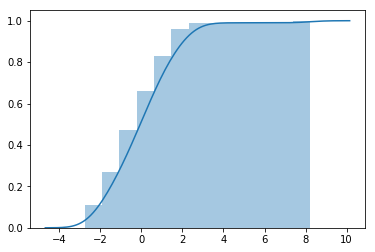

In [1056]:
sns.distplot(p1p.eigvals(), hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
print(m1p.eigvals_pipsi())
print(m1p.eigvals_psi())

[5.000000000000005, 1.3233868677672498, 1.3233868677672491, 1.323386867767249, -0.011725390971444857, -0.011725390971444979, -0.01172539097144518, -0.044300692628253646]
[8.890683737759158, 5.2466459071832166, 5.2466459071832166, 5.2466459071832166, -0.09380312777155854, -0.09380312777155854, -0.09380312777155854, -0.158953731085176]


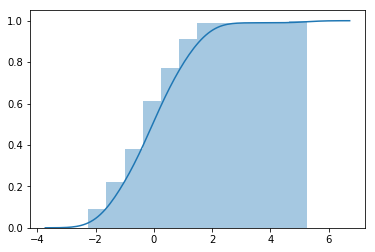

In [1057]:
sns.distplot(p2p.eigvals(), hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
print(m2p.eigvals_pipsi())
print(m2p.eigvals_psi())

In [1058]:
[i/j for (j, i) in zip(m3pc.eigvals_pipsi(), m3pc.eigvals_psi())]

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


[1.0000000000000027,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0]

[4.999999999999987, 1.505441376372314e-29, 1.3754466305216137e-29, 7.59723736290426e-30, 7.498267887171084e-30, 5.060368864600935e-30, 4.110105503469034e-30, 3.723536235094245e-30, 3.6139076933377736e-30, 2.3455509305257434e-30, 1.6259521343860863e-30, 1.3533654533935083e-30, 6.518021717364458e-31, 6.377708094083571e-31, 3.4951156465389124e-31, 3.369214758143618e-31, 3.369214758143618e-31, 1.022089431008125e-31, 2.443801874015435e-61, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.1399998253586235e-31, -3.2720251382276134e-31, -3.275966635508152e-31, -3.275966635508152e-31, -3.430944500123305e-31, -3.430944500123305e-31, -5.579106879197786e-31, -1.4404957962627977e-30, -1.4404957962627977e-30, -1.775658936298219e-30, -1.775658936298219e-30, -2.227646369384924e-30, -5.507424916297164e-30, -6.102360615550367e-30, -1.5179759161318678e-29]
[5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

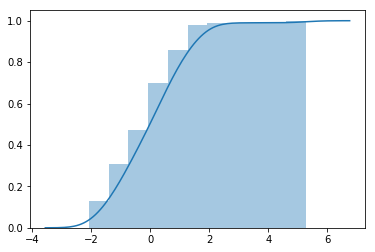

In [1059]:
sns.distplot(p3p.eigvals(), hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
print(m3p.eigvals_pipsi())
print(m3p.eigvals_psi())

In [962]:
import seaborn as sns